In [1]:
pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Timestamp
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import BlackLittermanModel, CovarianceShrinkage

import warnings
warnings.filterwarnings('ignore')

In [3]:
## 포트폴리오 데이터셋 생성
# 데이터 병합
sectors_data = {}
excel_file_path = 'stocks_2000_2020_data_by_sector.xlsx'
snp_price_data = pd.ExcelFile(excel_file_path)
for sheet_name in snp_price_data.sheet_names:
    sheet_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    sheet_data['Date'] = pd.to_datetime(sheet_data['Unnamed: 0'], format='%Y-%m-%d')
    sheet_data.set_index('Date', inplace=True)
    sheet_data.drop(columns='Unnamed: 0', inplace=True)
    sectors_data[sheet_name] = sheet_data

# 데이터프레임 생성
df = pd.DataFrame()
for sector, data in sectors_data.items():
    data.columns = [f"{sector}_{col}" for col in data.columns]
    if df.empty:
        df = data
    else:
        df = df.join(data, how='outer')

# 로그수익률 시계열 생성
return_df = np.log(df / df.shift(1))
return_df = return_df.dropna()

In [16]:
# 엑셀 파일에서 예측값 불러오기
predictions = pd.read_excel('model_predictions_logreturns.xlsx')
predictions = pd.DataFrame(np.array(predictions))

In [17]:
import numpy as np

def binarize_predictions(predictions):
    # 로그 수익률이 0보다 크면 상승(1), 그렇지 않으면 하락(0)으로 판단
    binary_predictions = np.where(predictions > 0, 1, -1)
    return binary_predictions

_predictions = binarize_predictions(predictions)


In [18]:
_predictions

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1]])

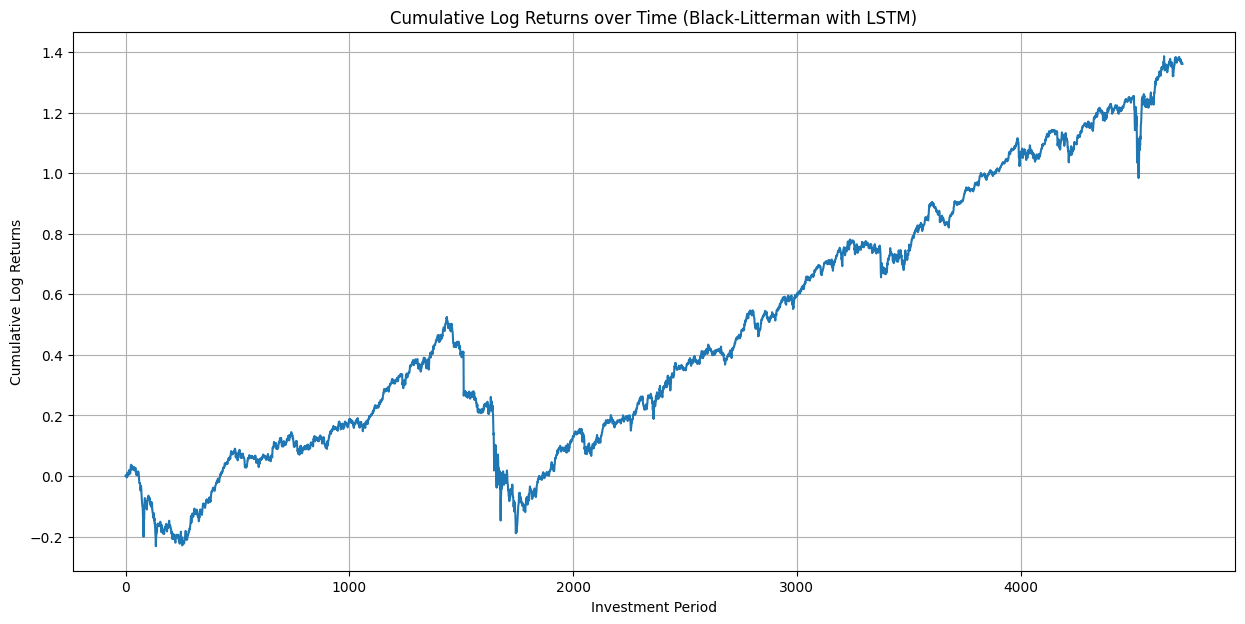

0 / 225


In [20]:
# 날짜 계산
learn_start_date = pd.Timestamp('2002-04-01')
learn_end_date = pd.Timestamp('2020-12-31')

# 누적 수익률 초기화
cumulative_returns = [0]

learn_data = pd.DataFrame()
invest_data = pd.DataFrame()
exception_indices = []
exception_values = []
exception_count = 0
i = 0

# 포트폴리오 최적화(블랙-리터만)과 리밸런싱
while learn_start_date < learn_end_date:
    start_of_learn = learn_start_date - pd.DateOffset(months=3)
    end_of_invest = learn_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    exception_occurred = False  # 예외 발생 여부를 추적하기 위한 플래그
    monthly_indices = []  # 이번 달의 인덱스를 저장할 리스트

    learn_data = df[(df.index >= start_of_learn) & (df.index < learn_start_date)]
    invest_data = df[(df.index >= learn_start_date) & (df.index <= end_of_invest)]
    invest_log_return = return_df[(return_df.index >= learn_start_date) & (return_df.index <= end_of_invest)]

    # 클러스터별 평균 수익률 추출 및 P, Q 행렬 구성
    Q = _predictions[i]
    Q = np.array(Q).reshape(-1, 1)
    P = np.zeros((55, len(learn_data.columns)))

    for k in range(55):
      P[k,k] = 1
    # print(P)
    # Omega 행렬
    omega = np.eye(55) * 0.01

    # 블랙리터만 뷰 설정 및 최적화
    S = CovarianceShrinkage(learn_data).ledoit_wolf()
    bl = BlackLittermanModel(S, P=P, Q=Q, omega=omega)
    ret_bl = bl.bl_returns()
    ef = EfficientFrontier(ret_bl, S)
    try:
      # weights = ef.max_sharpe()
      weights = ef.min_volatility()
    except:
      print('except')
      weights = {}
      exception_occurred = True  # 예외 발생 플래그 설정
      exception_count += 1  # 예외 발생 횟수 증가
      for j in learn_data.columns:
        weights[j] = 1/55 # 1/n 씩 투자했다고 가정
    # 일별수익률
    portfolio_log_return = (invest_log_return * pd.Series(weights)).sum(axis=1)
    new_cumulative_return = 0  # 누적 로그 수익률 초기화

    # 이 달에 대한 누적 수익률을 계산
    for daily_return in portfolio_log_return.tolist():
        new_cumulative_return = cumulative_returns[-1] + daily_return
        cumulative_returns.append(new_cumulative_return)
        if exception_occurred:
            monthly_indices.append(len(cumulative_returns) - 1)

    # 예외가 발생했다면 이 달의 인덱스를 exception_indices에 추가
    if exception_occurred:
        exception_indices.extend(monthly_indices)
        exception_values.extend([cumulative_returns[idx] for idx in monthly_indices])

    # portfolio_log_return = (invest_log_return * pd.Series(weights)).sum(axis=1)
    # cumulative_log_return = portfolio_log_return.sum()
    # # 누적 로그 수익률 업데이트
    # cumulative_returns.append(cumulative_returns[-1] + cumulative_log_return)

    # 다음 투자 update
    learn_start_date = learn_start_date + pd.DateOffset(months=1)  # 한 달씩 이동
    i += 1

plt.figure(figsize=(15, 7))
plt.plot(cumulative_returns)

# 예외가 발생한 인덱스에 대해 다른 색상으로 점 표시
plt.scatter(exception_indices, exception_values, color='r', marker='o',s=5, label='Exceptions')

plt.grid(True)
plt.xlabel('Investment Period')
plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative Log Returns over Time (Black-Litterman with LSTM)')
plt.show()
print(exception_count, "/", i)

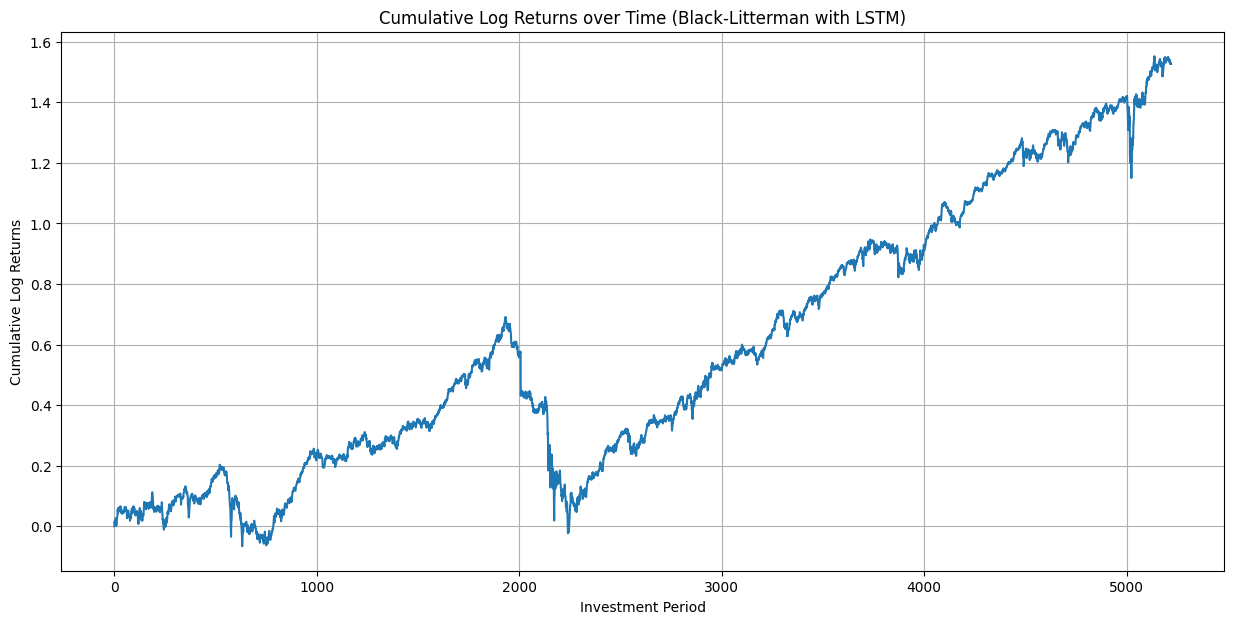

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(cumulative_returns)
plt.grid(True)
plt.xlabel('Investment Period')
plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative Log Returns over Time (Black-Litterman with LSTM)')
plt.show()